In [1]:
import torch
import pyro.distributions as dist
import pyro
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import Predictive
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
print(pyro.__version__)

1.8.2+2e3bd02


In [2]:
initial_probs = torch.tensor([0.5, 0.5])
transition_matrix = torch.tensor([[0.95, 0.05], 
                               [0.10, 0.90]])
emission_probs = torch.tensor([[1/6,  1/6,  1/6,  1/6,  1/6,  1/6],    # fair die
                            [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]])  # loaded die

print(f"A.shape: {transition_matrix.shape}")
print(f"B.shape: {emission_probs.shape}")

A.shape: torch.Size([2, 2])
B.shape: torch.Size([2, 6])


In [61]:
hmm = dist.DiscreteHMM(
    initial_logits=initial_probs.log(),
    transition_logits=transition_matrix.log(),
    observation_dist=dist.Categorical(emission_probs),
    duration=100
)

In [96]:
emissions = hmm.sample()
post_states = hmm.filter(emissions).sample([100])

In [97]:
print(f"First 5 states      : {post_states[:5]}")
print(f"First 5 emissions   : {emissions[:5]}")

First 5 states      : tensor([0, 0, 0, 0, 0])
First 5 emissions   : tensor([5, 5, 5, 0, 1])


In [85]:
one_hot = torch.nn.functional.one_hot(emissions, 6).T

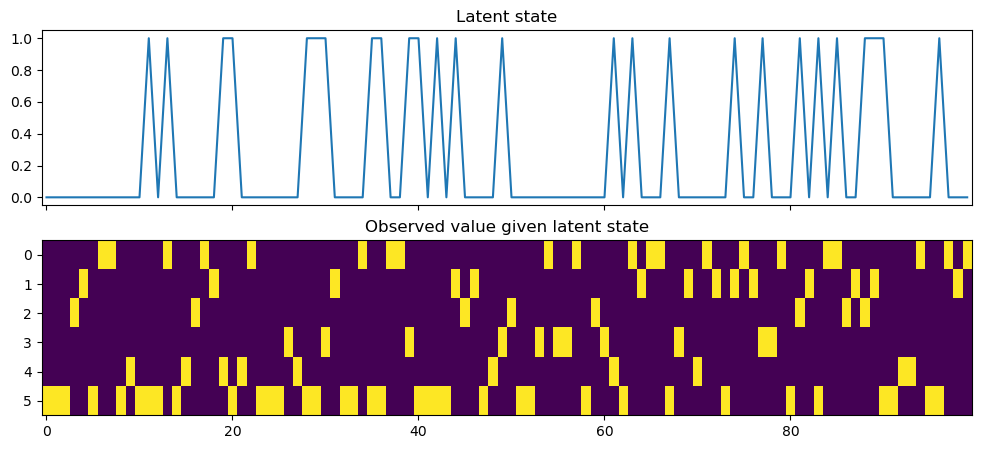

In [104]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 5))

ax[0].plot(torch.arange(0, 100), post_states)
ax[0].set_title('Latent state')
ax[1].imshow(one_hot, aspect='auto')
ax[1].set_title('Observed value given latent state');

In [81]:
def plot_sequences(states, emissions):

    one_hot = torch.nn.functional.one_hot(emissions[:, 0], 6).T
    
    plt.imshow()

SyntaxError: incomplete input (3354643835.py, line 2)